# Implementacija predikcije ocene parfema uz korišćenje _XGBoost_ i _Random Forest_

Pre svega treba importovati sve potrebne pakete koji će nam služiti za analizu.

In [88]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import re
from ast import literal_eval
import matplotlib.pyplot as plt

Funckija `parse_season_ratings()` služi za za parsiranje polja godišnjih doba iz skupa podataka, dok funckija `consolidate_notes()` objedinjuje/konsoliduje _base_, _middle_ i _top_ note u jednu kolekciju.

In [89]:
def parse_season_ratings(rating_str):
    pattern = r'([A-Za-z]+):\s*([0-9.]+)%'
    return {season: float(percent) for season, percent in re.findall(pattern, rating_str)}

def consolidate_notes(notes):
    all_notes = []
    for note_type in ['Top Notes', 'Middle Notes', 'Base Notes']:
        if note_type in notes:
            all_notes.extend(notes[note_type])
    return all_notes

Učitavanje skupa podataka:

In [90]:
file_path = "../datasets/mainDataset.csv"  
data = pd.read_csv(file_path, delimiter='|')

Prasiranje nekih relevantnih polja iz skupa podataka, zbog njihovog oblika čuvanja u _dataset_-u, koji će biti ulaz u algoritme. Koristila se metoda `literal_Eval()` za bezbedno parsiranje stringova koji predstavljaju _Python_ literale u stvarne _Python_ objekte.

In [91]:
data['Accords'] = data['Accords'].apply(literal_eval)
data['Notes'] = data['Notes'].apply(literal_eval)
data['Votes'] = data['Rating'].apply(lambda x: literal_eval(x)['votes'])
data['Rating'] = data['Rating'].apply(lambda x: literal_eval(x)['rating'])
data['Season ratings'] = data['Season ratings'].apply(parse_season_ratings)
data['Day ratings'] = data['Day ratings'].apply(parse_season_ratings)
data['Designers'] = data['Designers'].apply(literal_eval)

Izdvajanje relevantnih polja i stvaranje _record_-a i formiranje _Data Frame_-a koji sadrži svaki parfem iz skupa podataka u pogodnom obliku. _URL_ slike parfema i tekstualni opis nisu bili releventni za eksperiment, kao ni parfimeri a ni samo ime parfema.

In [92]:
records = []
for _, row in data.iterrows():
    records.append({
        "Brand": row["Brand"],
        "Accords": row["Accords"],
        "Gender": row["Gender"],
        "Longevity": row["Longevity"],
        "Sillage": row["Sillage"],
        "Rating": row["Rating"],
        "Votes" : row["Votes"],
        "Season_Winter": row["Season ratings"].get("Winter", 0),
        "Season_Spring": row["Season ratings"].get("Spring", 0),
        "Season_Summer": row["Season ratings"].get("Summer", 0),
        "Season_Fall": row["Season ratings"].get("Fall", 0),
        "Day": row["Day ratings"].get("Day", 0),
        "Night": row["Day ratings"].get("Night", 0)
    })

Formiran je _DataFrame_ u kojem su objedinjene sve note pojedinačnog parfema, bez razdvajanja na _top_, _middle_ i _base notes_, odnosno implementirano je konsolidovanje nota. U kasnijem primeru, biće razdvajanja nota nakon čega ćemo uporediti rezultate. 

Kada je u pitanju implementacija sa konsolidovanjem nota, model uči samo prisustvo ili odsustvo nota, a ne i njihovu hijerarhiju. To je kompromis: jednostavnija reprezentacija → jasniji signal, ali manje detalja.

In [93]:
structured_df = pd.DataFrame(records)
structured_df['All Notes'] = data['Notes'].apply(consolidate_notes)

Kategorijske kolone _Brand_ i _Gender_ su pretvorene u _one-hot_ enkodirane kolone, dok su sve jedinstvene note iz _All Notes_ pretvorene u binarne indikatorske kolone koje pokazuju prisustvo svake note, kao i akordi.

In [94]:
ohe = OneHotEncoder(sparse_output=False)
ohe_features = pd.DataFrame(
    ohe.fit_transform(structured_df[['Brand', 'Gender']]),
    columns=ohe.get_feature_names_out(['Brand', 'Gender'])
)

all_unique_notes = set(note for notes in structured_df['All Notes'] for note in notes)
note_df = pd.DataFrame(
    {f'Note_{note}': structured_df['All Notes'].apply(lambda x: 1 if note in x else 0)
     for note in all_unique_notes}
)

all_unique_accords = set(accord for accords in structured_df['Accords'] for accord in accords)
accord_df = pd.DataFrame(
    {f'Accord_{accord}': structured_df['Accords'].apply(lambda x: 1 if accord in x else 0)
     for accord in all_unique_accords}
)

structured_df = pd.concat([structured_df, note_df, accord_df], axis=1)

X = pd.concat([ohe_features, structured_df.drop(columns=['Brand', 'Gender', 'Rating', 'All Notes', 'Accords'])], axis=1)
y = structured_df['Rating']

Skup je podeljen na _test_ i _train_ deo.

In [95]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Pozivanje _Random Forest_-a.

In [96]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print("Random Forest R^2:", rf_model.score(X_test, y_test))
print("Random Forest MAE:", mean_absolute_error(y_test, y_pred))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

Random Forest R^2: 0.3845959988417259
Random Forest MAE: 0.15122271540469978
Random Forest RMSE: 0.19630818214221005


Pozivanje feature importance.

In [97]:
importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
#top_features = importances.sort_values(ascending=False).head(30)
#print(top_features)
#plt.figure(figsize=(10,6))
#top_features.plot(kind="barh")
#plt.title("Top 20 Feature Importances - Random Forest")
#plt.gca().invert_yaxis()
#plt.show()

Analizom _feature importance_ u okviru _Random Forest_ modela, utvrđeno je da su najznačajnije karakteristike za predikciju ocene parfema upravo mirisne note, kao i sezonska pripadnost parfema i njegova dugotrajnost. Ove osobine najviše doprinose tačnosti modela, jer direktno odražavaju mirisni profil i korisničke preferencije.

Brend, broj glasova (popularnost) i akordi parfema takođe imaju uticaj na predikciju, ali njihov značaj je manji u poređenju sa prethodno navedenim karakteristikama. Analiza je pokazala da preporuka za nošenje parfema tokom dana ili noći ima ograničen značaj (manje od 10%), dok je _Sillage_ (intenzitet mirisnog traga) još manje relevantan za model.

Najmanje značajna karakteristika je _Gender_, što ukazuje da polna pripadnost parfema sve manje utiče na korisničke ocene. Ovaj rezultat iskazuje praćenje savremenih trendova u industriji, gde se sve više kreiraju unisex parfemi, a izbor mirisa postaje lična preferenca, nezavisna od tradicionalnih polnih kategorija

Ukupna važnost Brand: 0.11041437725572815
Ukupna važnost Gender: 0.02367612318282602
Ukupna važnost Notes: 0.22768424084069133
Ukupna važnost Season: 0.1524929032367533
Ukupna važnost Day/Night: 0.08888473306921227
Važnost Longevity: 0.14370998799239046
Važnost Sillage: 0.033168192839749415
Važnost Votes: 0.11017793963857384
Brand        0.110414
Gender       0.023676
Notes        0.227684
Season       0.152493
Day/Night    0.088885
Longevity    0.143710
Sillage      0.033168
Votes        0.110178
Accords      0.109792
dtype: float64


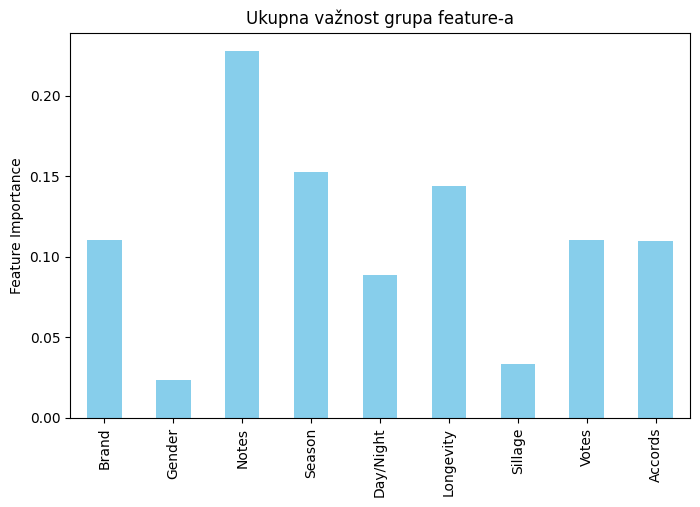

In [98]:
brand_importance = importances[importances.index.str.startswith("Brand_")].sum()
gender_importance = importances[importances.index.str.startswith("Gender_")].sum()
notes_importance = importances[importances.index.str.startswith("Note_")].sum()
season_importance = importances[importances.index.str.startswith("Season_")].sum()
day_night_importance = importances[importances.index.str.startswith("Day") | importances.index.str.startswith("Night")].sum()
longevity_importance = importances["Longevity"]
sillage_importance = importances["Sillage"]
votes_importance = importances["Votes"]
accords_importance = importances[importances.index.str.startswith("Accord_")].sum()

print("Ukupna važnost Brand:", brand_importance)
print("Ukupna važnost Gender:", gender_importance)
print("Ukupna važnost Notes:", notes_importance)
print("Ukupna važnost Season:", season_importance)
print("Ukupna važnost Day/Night:", day_night_importance)
print("Važnost Longevity:", longevity_importance)
print("Važnost Sillage:", sillage_importance)
print("Važnost Votes:", votes_importance)

group_importances = pd.Series({
    "Brand": brand_importance,
    "Gender": gender_importance,
    "Notes": notes_importance,
    "Season": season_importance,
    "Day/Night": day_night_importance,
    "Longevity": longevity_importance,
    "Sillage": sillage_importance,
    "Votes": votes_importance,
    "Accords" : accords_importance
})

# Print rezultata
print(group_importances)

# Vizualizacija
plt.figure(figsize=(8,5))
group_importances.plot(kind="bar", color="skyblue")
plt.title("Ukupna važnost grupa feature-a")
plt.ylabel("Feature Importance")
plt.show()

Implementacija bez konsolidovanja nota:

In [125]:
def extract_top_notes(x):
    if isinstance(x, dict):
        return x.get('Top Notes', [])
    elif isinstance(x, list):
        return []
    else:
        return []

def extract_middle_notes(x):
    if isinstance(x, dict):
        return x.get('Middle Notes', [])
    elif isinstance(x, list):
        return []
    else:
        return []

def extract_base_notes(x):
    if isinstance(x, dict):
        return x.get('Base Notes', [])
    elif isinstance(x, list):
        return x  # If notes are a list, put all in base
    else:
        return []

structured_df = pd.DataFrame(records)
structured_df['Top_Notes'] = data['Notes'].apply(extract_top_notes)
structured_df['Middle_Notes'] = data['Notes'].apply(extract_middle_notes)
structured_df['Base_Notes'] = data['Notes'].apply(extract_base_notes)

In [126]:
ohe = OneHotEncoder(sparse_output=False)
ohe_features = pd.DataFrame(
    ohe.fit_transform(structured_df[['Brand', 'Gender']]),
    columns=ohe.get_feature_names_out(['Brand', 'Gender'])
)

all_unique_top_notes = set(note for notes in structured_df['Top_Notes'] for note in notes)
top_note_df = pd.DataFrame(
    {f'Top_Notes_{note}': structured_df['Top_Notes'].apply(lambda x: 1 if note in x else 0)
     for note in all_unique_top_notes}
)

all_unique_middle_notes = set(note for notes in structured_df['Middle_Notes'] for note in notes)
middle_note_df = pd.DataFrame(
    {f'Middle_Notes_{note}': structured_df['Middle_Notes'].apply(lambda x: 1 if note in x else 0)
     for note in all_unique_middle_notes}
)

all_unique_base_notes = set(note for notes in structured_df['Base_Notes'] for note in notes)
base_note_df = pd.DataFrame(
    {f'Base_Notes_{note}': structured_df['Base_Notes'].apply(lambda x: 1 if note in x else 0)
     for note in all_unique_base_notes}
)

all_unique_accords = set(accord for accords in structured_df['Accords'] for accord in accords)
accord_df = pd.DataFrame(
    {f'Accord_{accord}': structured_df['Accords'].apply(lambda x: 1 if accord in x else 0)
     for accord in all_unique_accords}
)

structured_df = pd.concat([structured_df, top_note_df, middle_note_df, base_note_df, accord_df], axis=1)

X = pd.concat([ohe_features, structured_df.drop(columns=['Brand', 'Gender', 'Rating', 'Top_Notes', 'Middle_Notes', 'Base_Notes', 'Accords'])], axis=1)
y = structured_df['Rating']

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [128]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print("Random Forest R^2:", rf_model.score(X_test, y_test))
print("Random Forest MAE:", mean_absolute_error(y_test, y_pred))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

Random Forest R^2: 0.37391547190940855
Random Forest MAE: 0.15315613577023507
Random Forest RMSE: 0.1980043490568599


In [129]:
importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
#top_features = importances.sort_values(ascending=False).head(30)
#print(top_features)
#plt.figure(figsize=(10,6))
#top_features.plot(kind="barh")
#plt.title("Top 20 Feature Importances - Random Forest")
#plt.gca().invert_yaxis()
#plt.show()

Ukupna važnost Brand: 0.10294366668857569
Ukupna važnost Gender: 0.024404698022200237
Ukupna važnost Top Notes: 0.0898343141511401
Ukupna važnost Middle Notes: 0.0797763628712677
Ukupna važnost Base Notes: 0.06873285711651532
Ukupna važnost Season: 0.15240433930639113
Ukupna važnost Day/Night: 0.08620275880863826
Važnost Longevity: 0.14286610950357337
Važnost Sillage: 0.03453847430341271
Važnost Votes: 0.11158306203009895
Brand           0.102944
Gender          0.024405
Top Notes       0.089834
Middle Notes    0.079776
Base Notes      0.068733
Season          0.152404
Day/Night       0.086203
Longevity       0.142866
Sillage         0.034538
Votes           0.111583
Accords         0.106713
dtype: float64


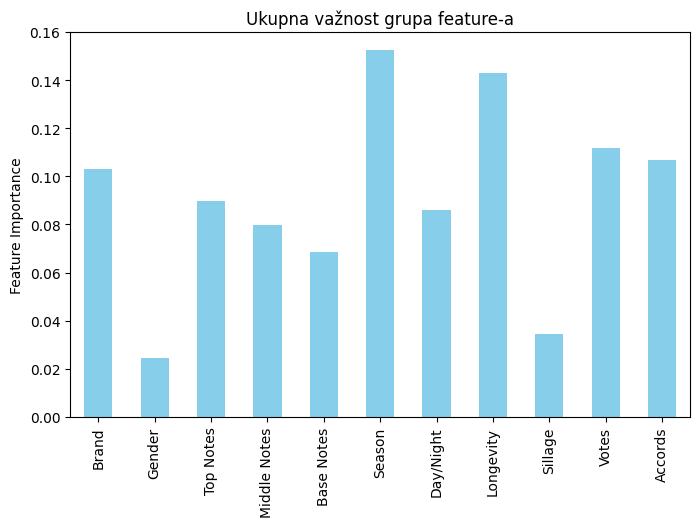

In [130]:
brand_importance = importances[importances.index.str.startswith("Brand_")].sum()
gender_importance = importances[importances.index.str.startswith("Gender_")].sum()
top_notes_importance = importances[importances.index.str.startswith("Top_")].sum()
middle_notes_importance = importances[importances.index.str.startswith("Middle_")].sum()
base_notes_importance = importances[importances.index.str.startswith("Base_")].sum()
season_importance = importances[importances.index.str.startswith("Season_")].sum()
day_night_importance = importances[importances.index.str.startswith("Day") | importances.index.str.startswith("Night")].sum()
longevity_importance = importances["Longevity"]
sillage_importance = importances["Sillage"]
votes_importance = importances["Votes"]
accords_importance = importances[importances.index.str.startswith("Accord_")].sum()

print("Ukupna važnost Brand:", brand_importance)
print("Ukupna važnost Gender:", gender_importance)
print("Ukupna važnost Top Notes:", top_notes_importance)
print("Ukupna važnost Middle Notes:", middle_notes_importance)
print("Ukupna važnost Base Notes:", base_notes_importance)
print("Ukupna važnost Season:", season_importance)
print("Ukupna važnost Day/Night:", day_night_importance)
print("Važnost Longevity:", longevity_importance)
print("Važnost Sillage:", sillage_importance)
print("Važnost Votes:", votes_importance)

group_importances = pd.Series({
    "Brand": brand_importance,
    "Gender": gender_importance,
    "Top Notes": top_notes_importance,
    "Middle Notes": middle_notes_importance,
    "Base Notes": base_notes_importance,
    "Season": season_importance,
    "Day/Night": day_night_importance,
    "Longevity": longevity_importance,
    "Sillage": sillage_importance,
    "Votes": votes_importance,
    "Accords" : accords_importance
})

# Print rezultata
print(group_importances)

# Vizualizacija
plt.figure(figsize=(8,5))
group_importances.plot(kind="bar", color="skyblue")
plt.title("Ukupna važnost grupa feature-a")
plt.ylabel("Feature Importance")
plt.show()

Rezultati pokazuju da razlike između dve implementacije _Random Forest_ modela, tj. one sa konsolidovanim notama i one sa razdvojenim (_top_, _middle_, _base_) notama, nisu značajne. Model bez konsolidovanja nota ostvaruje nešto bolji _R^2_ rezultat, ali je ta razlika minimalna (~ 0.01). Vrednosti _MAE_ i _RMSE_ su gotovo identične u oba pristupa, što ukazuje da način predstavljanja nota nema presudan uticaj na ukupnu tačnost modela.

Konsolidovanje nota pojednostavljuje strukturu podataka, omogućavajući modelu da uči na osnovu prisustva ili odsustva mirisnih komponenti, bez obzira na njihovu hijerarhiju. S druge strane, razdvajanje nota po tipu može potencijalno otkriti nijanse u uticaju pojedinih grupa nota, ali se u ovom eksperimentu pokazalo da takva granularnost ne donosi značajno poboljšanje performansi.

Dodatno, analiza značaja karakteristika (_feature importance_) pokazuje da su mirisne note, sezonska pripadnost i dugotrajnost parfema najvažniji faktori za predikciju ocene, dok brend, broj glasova i akordi imaju manji značaj. Polna kategorija parfema (_Gender_) ima najmanji uticaj, što je u skladu sa savremenim trendovima u industriji.

Pozivanje _XGBoost_-a.

In [99]:
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)
y_xgb_pred = xgb_model.predict(X_test)

print("XGBoost R^2:", xgb_model.score(X_test, y_test))
print("XGBoost MAE:", mean_absolute_error(y_test, y_xgb_pred))
print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_xgb_pred)))

XGBoost R^2: 0.28081412679495943
XGBoost MAE: 0.1627535074995952
XGBoost RMSE: 0.2122163387687283


Analiza _feature importance_ u okviru _XGBoost_ modela pokazuje značajnu razliku u odnosu na _Random Forest_ pristup. Kod _XGBoost_-a, jedine karakteristike koje se izdvajaju kao relevantne za predikciju ocene parfema su mirisne note (_Notes_), brend (_Brand_) i akordi (_Accords_). Ostale osobine, poput sezonske pripadnosti, dugotrajnosti, intenziteta mirisnog traga, broja glasova ili polne kategorije, nisu se pokazale kao značajne za ovaj model.

Ovakav rezultat ukazuje da _XGBoost_ algoritam najefikasnije koristi informacije o osnovnim mirisnim komponentama i poreklu parfema, dok dodatni deskriptivni podaci ne doprinose značajno tačnosti predikcije. Time se potvrđuje da je za _XGBoost_ model ključan fokus na mirisnom profilu i brendu, dok se ostale karakteristike ne mogu smatrati relevantnim u procesu učenja.

Ukupna važnost Brand: 0.28035188
Ukupna važnost Gender: 0.017851654
Ukupna važnost Notes: 0.4929208
Ukupna važnost Season: 0.019870238
Ukupna važnost Day/Night: 0.011339778
Važnost Longevity: 0.006240642
Važnost Sillage: 0.0024734067
Važnost Votes: 0.0076258723
Brand        0.280352
Gender       0.017852
Notes        0.492921
Season       0.019870
Day/Night    0.011340
Longevity    0.006241
Sillage      0.002473
Votes        0.007626
Accords      0.161326
dtype: float32


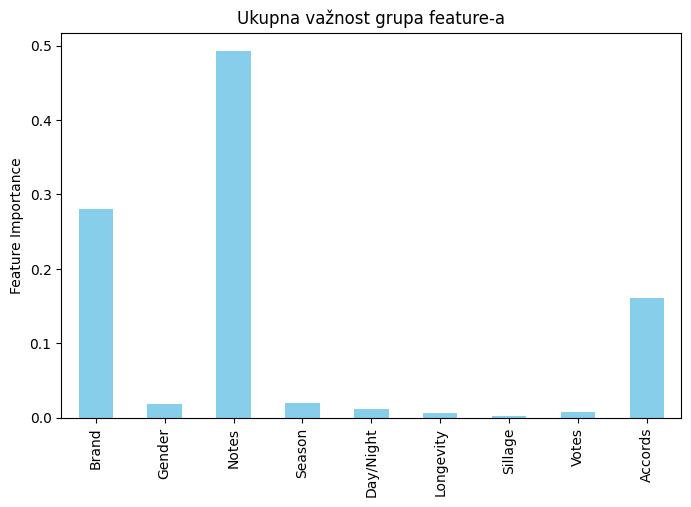

In [100]:
importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns)
brand_importance = importances[importances.index.str.startswith("Brand_")].sum()
gender_importance = importances[importances.index.str.startswith("Gender_")].sum()
notes_importance = importances[importances.index.str.startswith("Note_")].sum()
season_importance = importances[importances.index.str.startswith("Season_")].sum()
day_night_importance = importances[importances.index.str.startswith("Day") | importances.index.str.startswith("Night")].sum()
longevity_importance = importances["Longevity"]
sillage_importance = importances["Sillage"]
votes_importance = importances["Votes"]
accords_importance = importances[importances.index.str.startswith("Accord_")].sum()

print("Ukupna važnost Brand:", brand_importance)
print("Ukupna važnost Gender:", gender_importance)
print("Ukupna važnost Notes:", notes_importance)
print("Ukupna važnost Season:", season_importance)
print("Ukupna važnost Day/Night:", day_night_importance)
print("Važnost Longevity:", longevity_importance)
print("Važnost Sillage:", sillage_importance)
print("Važnost Votes:", votes_importance)

group_importances = pd.Series({
    "Brand": brand_importance,
    "Gender": gender_importance,
    "Notes": notes_importance,
    "Season": season_importance,
    "Day/Night": day_night_importance,
    "Longevity": longevity_importance,
    "Sillage": sillage_importance,
    "Votes": votes_importance,
    "Accords" : accords_importance
})

# Print rezultata
print(group_importances)

# Vizualizacija
plt.figure(figsize=(8,5))
group_importances.plot(kind="bar", color="skyblue")
plt.title("Ukupna važnost grupa feature-a")
plt.ylabel("Feature Importance")
plt.show()

Probali smo da uklonimo karakteristike koje se nisu pokazale kao bitne, ali dobili smo _MAE_ losiji za 0.01.

Sledi implementacija sa konsolidovanjem nota:

In [101]:
recordsForXGB = []
for _, row in data.iterrows():
    recordsForXGB.append({
        "Brand": row["Brand"],
        "Accords": row["Accords"],
        "Rating": row["Rating"]
    })

Formira se novi _DataFrame_ `structured_df_XGB` koji sadrži ključne informacije o svakom parfemu relevantne za _XGBoost_ modeliranje, uključujući brend, akorde i ocenu. Zatim se, korišćenjem funkcije `consolidate_notes`, objedinjene sve mirisne note (_top_, _middle_, _base_) u jednu kolonu _All Notes_. Ova konsolidacija omogućava da se mirisni profil svakog parfema predstavi kao jedinstvena kolekcija nota, čime se pojednostavljuje dalja obrada podataka i priprema za enkodiranje i modeliranje

In [102]:
structured_df_XGB = pd.DataFrame(recordsForXGB)
structured_df_XGB['All Notes'] = data['Notes'].apply(consolidate_notes)

U narednoj ćeliji se vrši priprema podataka za _XGBoost_ model kroz enkodiranje i transformaciju relevantnih karakteristika.

Prvo se brendovi parfema iz kolone _Brand_ pretvaraju u binarne (_one-hot_) enkodirane kolone pomoću `OneHotEncoder`, čime se omogućava modelu da efikasno koristi kategorijske podatke. Zatim se iz kolone _All Notes_ izdvajaju sve jedinstvene mirisne note, za svaku od njih se kreira posebna binarna kolona koja označava prisustvo ili odsustvo te note u parfemu. Sličan postupak se primenjuje i na akorde iz kolone _Accords_, gde se za svaki jedinstveni akord formira binarna indikatorska kolona. Na kraju, sve transformisane kolone se spajaju u jedan _DataFrame_, dok se ciljna promenljiva (`y_novo`) definiše kao ocena parfema.

In [103]:
ohe = OneHotEncoder(sparse_output=False)
ohe_features = pd.DataFrame(
    ohe.fit_transform(structured_df_XGB[['Brand']]),
    columns=ohe.get_feature_names_out(['Brand'])
)

all_unique_notes = set(note for notes in structured_df_XGB['All Notes'] for note in notes)
note_df = pd.DataFrame(
    {f'Note_{note}': structured_df_XGB['All Notes'].apply(lambda x: 1 if note in x else 0)
     for note in all_unique_notes}
)

all_unique_accords = set(accord for accords in structured_df_XGB['Accords'] for accord in accords)
accord_df = pd.DataFrame(
    {f'Accord_{accord}': structured_df_XGB['Accords'].apply(lambda x: 1 if accord in x else 0)
     for accord in all_unique_accords}
)

structured_df_XGB = pd.concat([structured_df_XGB, note_df, accord_df], axis=1)

X_novo = pd.concat([ohe_features, structured_df_XGB.drop(columns=['Brand', 'Rating', 'All Notes', 'Accords'])], axis=1)
y_novo = structured_df_XGB['Rating']

Podela na trening i test skup:

In [104]:
X_train_novo, X_test_novo, y_train_novo, y_test_novo = train_test_split(X_novo, y_novo, test_size=0.2, random_state=42)

U ovoj ćeliji se vrši treniranje i evaluacija _XGBoost_ regresionog modela na pripremljenim podacima. Model se obučava na trening skupu (`X_train_novo`, `y_train_novo`), a zatim se koristi za predikciju ocena parfema na test skupu (`X_test_novo`). Kvalitet modela se procenjuje pomoću tri ključne metrike: _R^2_, _MAE_ i _RMSE_. Ove metrike omogućavaju objektivnu procenu tačnosti predikcije i poređenje performansi modela sa drugim pristupima. Rezultati jasno pokazuju koliko je _XGBoost_ efikasan u predviđanju korisničkih ocena parfema na osnovu mirisnog profila i brenda.

In [105]:
xgb_model_novo = XGBRegressor(random_state=42)
xgb_model_novo.fit(X_train_novo, y_train_novo)
y_xgb_pred = xgb_model_novo.predict(X_test_novo)

print("XGBoost R^2:", xgb_model_novo.score(X_test_novo, y_test_novo))
print("XGBoost MAE:", mean_absolute_error(y_test_novo, y_xgb_pred))
print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test_novo, y_xgb_pred)))

XGBoost R^2: 0.2054081880032761
XGBoost MAE: 0.17194012527366215
XGBoost RMSE: 0.22306441122524712


U narednoj ćeliji se analizira značaj (_feature importance_) glavnih grupa karakteristika u okviru treniranog _XGBoost_ modela. Izračunava se ukupna važnost za brend parfema (_Brand_), mirisne note (_Notes_) i akorde (_Accords_) na osnovu vrednosti koje je model dodelio svakoj grupi tokom učenja. Rezultati se prikazuju numerički i grafički, što omogućava vizuelnu interpretaciju doprinosa svake grupe karakteristika u predikciji ocene parfema.

Ukupna važnost Brand: 0.2829798
Ukupna važnost Notes: 0.5718079
Ukupna važnost Notes: 0.14521231
Brand      0.282980
Notes      0.571808
Accords    0.145212
dtype: float32


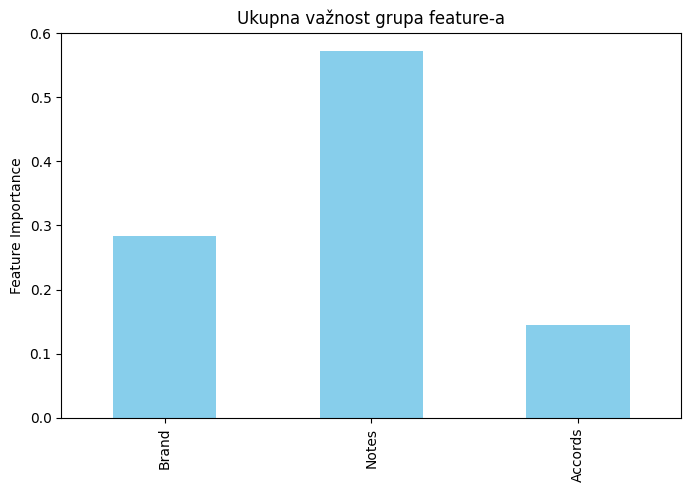

In [106]:
importances = pd.Series(xgb_model_novo.feature_importances_, index=X_train_novo.columns)
brand_importance = importances[importances.index.str.startswith("Brand_")].sum()
notes_importance = importances[importances.index.str.startswith("Note_")].sum()
accords_importance = importances[importances.index.str.startswith("Accord_")].sum()

print("Ukupna važnost Brand:", brand_importance)
print("Ukupna važnost Notes:", notes_importance)
print("Ukupna važnost Notes:", accords_importance)

group_importances = pd.Series({
    "Brand": brand_importance,
    "Notes": notes_importance,
    "Accords" : accords_importance
})

# Print rezultata
print(group_importances)

# Vizualizacija
plt.figure(figsize=(8,5))
group_importances.plot(kind="bar", color="skyblue")
plt.title("Ukupna važnost grupa feature-a")
plt.ylabel("Feature Importance")
plt.show()

_XGBoost_ model jasno ističe da su mirisne note, brend i akordi najvažnije karakteristike za predikciju ocene parfema. Ostale osobine, poput sezonske pripadnosti, polne kategorije, dugotrajnosti, intenziteta mirisnog traga i broja glasova, imaju zanemarljiv uticaj na model. Vizualizacija značaja grupa karakteristika dodatno potvrđuje da je mirisni profil (kombinacija nota i akorda) i poreklo parfema (brend) ključ za uspešnu predikciju korisničke ocene, dok dodatni deskriptivni podaci ne doprinose značajno tačnosti modela.

Ukoliko uklonimo konsolidovanje nota (`apply(consolidate_notes)`), dobijamo bolje rezultate za _R^2_ (~ 0.06), dok _MAE_ je malo lošiji (~ 0.01). A uklanjanjem _feature_-a koji nisu bili od velike važnosti, dobijamo znatno poboljšanje od ~ 0.08.

In [ ]:
recordsForXGB = []
for _, row in data.iterrows():
    recordsForXGB.append({
        "Brand": row["Brand"],
        "Accords": row["Accords"],
        "Rating": row["Rating"]
    })

def extract_top_notes(x):
    if isinstance(x, dict):
        return x.get('Top Notes', [])
    elif isinstance(x, list):
        return []
    else:
        return []

def extract_middle_notes(x):
    if isinstance(x, dict):
        return x.get('Middle Notes', [])
    elif isinstance(x, list):
        return []
    else:
        return []

def extract_base_notes(x):
    if isinstance(x, dict):
        return x.get('Base Notes', [])
    elif isinstance(x, list):
        return x  # If notes are a list, put all in base
    else:
        return []

In [108]:
structured_df_XGB = pd.DataFrame(recordsForXGB)
structured_df_XGB['Top_Notes'] = data['Notes'].apply(extract_top_notes)
structured_df_XGB['Middle_Notes'] = data['Notes'].apply(extract_middle_notes)
structured_df_XGB['Base_Notes'] = data['Notes'].apply(extract_base_notes)

In [109]:
ohe = OneHotEncoder(sparse_output=False)
ohe_features = pd.DataFrame(
    ohe.fit_transform(structured_df_XGB[['Brand']]),
    columns=ohe.get_feature_names_out(['Brand'])
)

all_unique_top_notes = set(note for notes in structured_df_XGB['Top_Notes'] for note in notes)
top_note_df = pd.DataFrame(
    {f'Top_Note_{note}': structured_df_XGB['Top_Notes'].apply(lambda x: 1 if note in x else 0)
     for note in all_unique_top_notes}
)

all_unique_middle_notes = set(note for notes in structured_df_XGB['Middle_Notes'] for note in notes)
middle_note_df = pd.DataFrame(
    {f'Middle_Note_{note}': structured_df_XGB['Middle_Notes'].apply(lambda x: 1 if note in x else 0)
     for note in all_unique_middle_notes}
)

all_unique_base_notes = set(note for notes in structured_df_XGB['Base_Notes'] for note in notes)
base_note_df = pd.DataFrame(
    {f'Base_Note_{note}': structured_df_XGB['Base_Notes'].apply(lambda x: 1 if note in x else 0)
     for note in all_unique_base_notes}
)

all_unique_accords = set(accord for accords in structured_df_XGB['Accords'] for accord in accords)
accord_df = pd.DataFrame(
    {f'Accord_{accord}': structured_df_XGB['Accords'].apply(lambda x: 1 if accord in x else 0)
     for accord in all_unique_accords}
)

structured_df_XGB = pd.concat([structured_df_XGB, top_note_df, middle_note_df, base_note_df, accord_df], axis=1)

X_novo = pd.concat([ohe_features, structured_df_XGB.drop(columns=['Brand', 'Rating', 'Top_Notes', 'Middle_Notes', 'Base_Notes', 'Accords'])], axis=1)
y_novo = structured_df_XGB['Rating']

In [110]:
X_train_novo, X_test_novo, y_train_novo, y_test_novo = train_test_split(X_novo, y_novo, test_size=0.2, random_state=42)

In [111]:
xgb_model_novo = XGBRegressor(random_state=42)
xgb_model_novo.fit(X_train_novo, y_train_novo)
y_xgb_pred = xgb_model_novo.predict(X_test_novo)

print("XGBoost R^2:", xgb_model_novo.score(X_test_novo, y_test_novo))
print("XGBoost MAE:", mean_absolute_error(y_test_novo, y_xgb_pred))
print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test_novo, y_xgb_pred)))

XGBoost R^2: 0.13999422094531466
XGBoost MAE: 0.17862738942975473
XGBoost RMSE: 0.23206461700817513


Ukupna važnost Brand: 0.24720517
Ukupna važnost Top Notes: 0.22722621
Ukupna važnost Middle Notes: 0.23774156
Ukupna važnost Base Notes: 0.17878422
Ukupna važnost Accords: 0.10904291
Brand           0.247205
Top Notes       0.227226
Middle Notes    0.237742
Base Notes      0.178784
Accords         0.109043
dtype: float32


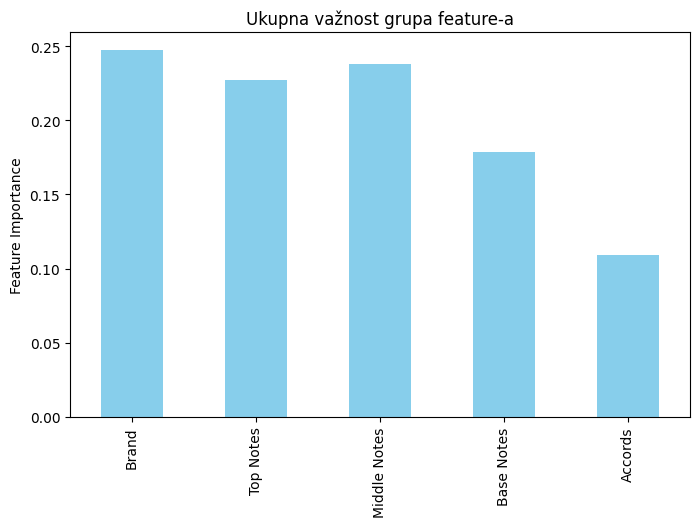

In [112]:
importances = pd.Series(xgb_model_novo.feature_importances_, index=X_train_novo.columns)
brand_importance = importances[importances.index.str.startswith("Brand_")].sum()
top_notes_importance = importances[importances.index.str.startswith("Top_")].sum()
middle_notes_importance = importances[importances.index.str.startswith("Middle_")].sum()
base_notes_importance = importances[importances.index.str.startswith("Base_")].sum()
accords_importance = importances[importances.index.str.startswith("Accord_")].sum()

print("Ukupna važnost Brand:", brand_importance)
print("Ukupna važnost Top Notes:", top_notes_importance)
print("Ukupna važnost Middle Notes:", middle_notes_importance)
print("Ukupna važnost Base Notes:", base_notes_importance)
print("Ukupna važnost Accords:", accords_importance)

group_importances = pd.Series({
    "Brand": brand_importance,
    "Top Notes": top_notes_importance,
    "Middle Notes": middle_notes_importance,
    "Base Notes": base_notes_importance,
    "Accords" : accords_importance
})

# Print rezultata
print(group_importances)

# Vizualizacija
plt.figure(figsize=(8,5))
group_importances.plot(kind="bar", color="skyblue")
plt.title("Ukupna važnost grupa feature-a")
plt.ylabel("Feature Importance")
plt.show()